# Create overview of observations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.coordinates as coord

In [2]:
# Obtain results
tbl = pd.read_csv('good_table.csv')
display(tbl.head())

,Source,Filter,Obs_number,Detected Name,Date obs,RA,DEC,Error_circle (arcsec),Position_source,nH,...,Flux_err,Distance (kpc),Distance_error,Distance_source,Lum,Lum_err,Xray_Flux (erg/s/cm2),Xray_Flux_err,Xray_Flux_source,Comments
0,RX_J1735.3-3540,J,3081,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",5.760000e+21,...,1.790000e-14,<= 9.5,NaN,Degenaar+2010,NaN,NaN,2.000000e-11,5.000000e-12,Thesis Bilal 2018,NaN
1,RX_J1735.3-3540,J,3090,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",5.760000e+21,...,1.800000e-14,<= 9.5,NaN,Degenaar+2010,NaN,NaN,2.000000e-11,5.000000e-12,Thesis Bilal 2018,NaN
2,RX_J1735.3-3540,H,3063,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",5.760000e+21,...,1.970000e-14,<= 9.5,NaN,Degenaar+2010,NaN,NaN,2.000000e-11,5.000000e-12,Thesis Bilal 2018,Initially very large magnitude offset but seem...
3,RX_J1735.3-3540,H,3072,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",5.760000e+21,...,2.280000e-14,<= 9.5,NaN,Degenaar+2010,NaN,NaN,2.000000e-11,5.000000e-12,Thesis Bilal 2018,Initially large magnitude offset but seems oka...
4,RX_J1735.3-3540,Ks,3045,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",5.760000e+21,...,1.870000e-14,<= 9.5,NaN,Degenaar+2010,NaN,NaN,2.000000e-11,5.000000e-12,Thesis Bilal 2018,Initially large magnitude offset but seems oka...


In [3]:
# Throw away upper limits
tbl_mags = tbl[tbl['Detected Name'].notna()]

In [4]:
# Print some general info about number of observations
print('total amount of good observations:', len(tbl))
print('sources:', len(tbl.groupby('Source')))
print('amount of upper limits:', len(tbl) - len(tbl_mags))
print('amount of sources with magnitude measurement (no upplim):', len(tbl_mags.groupby('Source')))

total amount of good observations: 141
sources: 38
amount of upper limits: 30
amount of sources with magnitude measurement (no upplim): 31


## Investigate differences between bands

In [27]:
''' 
Investigate difference between mean magnitudes in 
J and Ks band
'''

source_list = tbl_mags['Source'].unique()
dif_list = []
dif_list_rel = []

for i, s in enumerate(source_list):
    
    # Get Ks magnitude
    Ks_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'Ks')]
    if len(Ks_obs) > 1:
        Ks_mag = np.mean(Ks_obs['Mag_corr'])
    else: 
        Ks_mag = np.mean(Ks_obs['Mag_corr'])
        
    # Get J magnitude
    J_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'J')]
    if len(J_obs) > 1:
        J_mag = np.mean(J_obs['Mag_corr'])
    else: 
        J_mag = np.mean(J_obs['Mag_corr'])
        
    # Calculate magnitude difference
    mag_dif = J_mag/2214.62 - Ks_mag/3163.40 
    dif_list.append(mag_dif)
    dif_list_rel.append(mag_dif/J_mag*2214.62)
    
    if np.abs(mag_dif) > 2:
        print('Source with very large difference:', s, ',   difference: ', mag_dif)


In [28]:
print(dif_list)
print(len(dif_list))

[0.002279474500118411, 0.0029265236301349905, 0.00284753116643902, 0.0020348200789358324, 0.003114102257112031, 0.0024670155155153495, 0.0027826411221009333, 0.0025866464651085547, nan, nan, 0.0035035520633210325, nan, 0.0025393466390877667, nan, nan, 0.0025170002223261325, 0.002838505048576567, 0.0023475635969560987, 0.0024288777441114767, 0.002433512333322076, nan, 0.0025908903396589435, 0.0031061873245309428, nan, nan, nan, nan, nan, nan, 0.002101528879317663, 0.0026747256898461778]
31


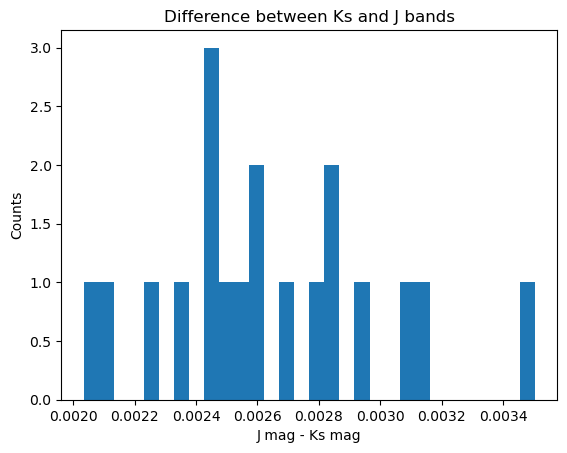

amount of data points 19


In [30]:
plt.hist(dif_list, bins=30)
plt.xlabel('J mag - Ks mag')
plt.ylabel('Counts')
plt.title('Difference between Ks and J bands')
plt.show()
print('amount of data points', len([x for x in dif_list if (np.isnan(x) == False)]))

# plt.hist(dif_list_rel, bins=30)
# plt.xlabel('J mag - Ks mag')
# plt.ylabel('Counts')
# plt.title('Difference between Ks and J bands')
# plt.show()

In [8]:
''' 
Investigate difference between mean magnitudes in 
all bands. 
'''

source_list = tbl_mags['Source'].unique()
dif_list_KJ = []
dif_list_JH = []
dif_list_HK = []

for i, s in enumerate(source_list):
    
    # Skip this source because different year in Ks band
    if s == 'Swift_J1910.2-0546':
        continue
        
    # Get Ks magnitude
    Ks_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'Ks')]
    if len(Ks_obs) > 1:
        Ks_mag = np.mean(Ks_obs['Mag_corr'])
    else: 
        Ks_mag = np.mean(Ks_obs['Mag_corr'])
        
    # Get J magnitude
    J_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'J')]
    if len(J_obs) > 1:
        J_mag = np.mean(J_obs['Mag_corr'])
    else: 
        J_mag = np.mean(J_obs['Mag_corr'])
        
    # Get H magnitude
    H_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'H')]
    if len(H_obs) > 1:
        H_mag = np.mean(H_obs['Mag_corr'])
    else: 
        H_mag = np.mean(H_obs['Mag_corr'])
        
    # Calculate magnitude difference
    mag_dif_KJ = J_mag - Ks_mag
    dif_list_KJ.append(mag_dif_KJ)
    mag_dif_JH = J_mag - H_mag
    dif_list_JH.append(mag_dif_JH)    
    mag_dif_HK = H_mag - Ks_mag
    dif_list_HK.append(mag_dif_HK)    


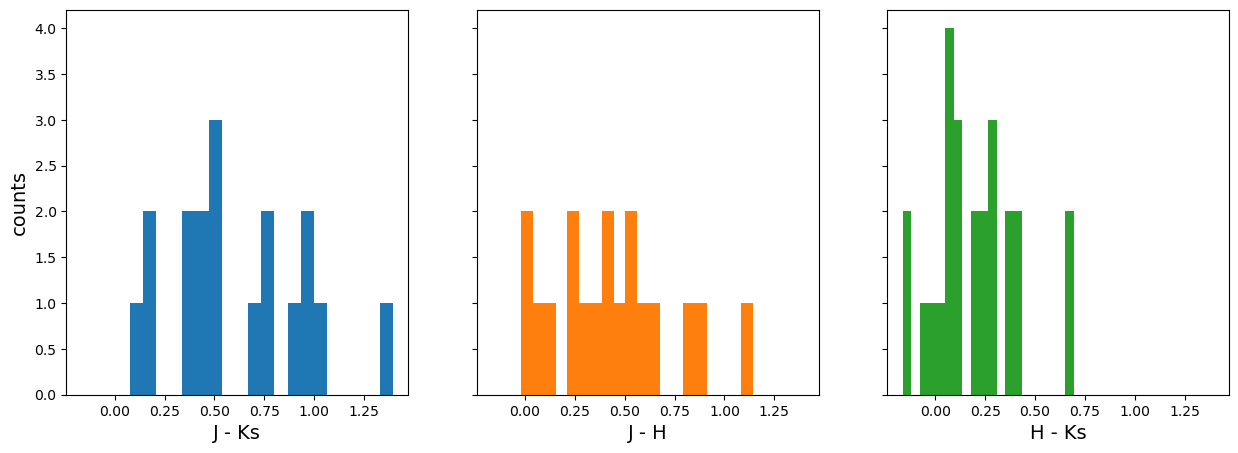

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharey=True, sharex=True)
ax1.hist(dif_list_KJ, bins=20)
ax1.set_xlabel('J - Ks', fontsize=14)
ax2.hist(dif_list_JH, bins=20, color='C1')
ax2.set_xlabel('J - H', fontsize=14)
ax3.hist(dif_list_HK, bins=20, color='C2')
ax3.set_xlabel('H - Ks', fontsize=14)
ax1.set_ylabel('counts', fontsize=14)
plt.show()


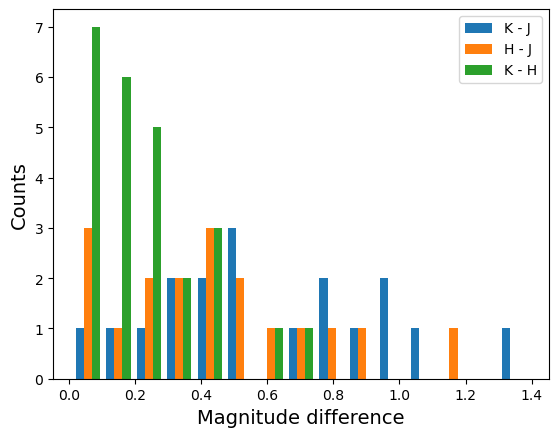

In [10]:
labels = ['K - J', 'H - J', 'K - H']
plt.hist([np.abs(dif_list_KJ), np.abs(dif_list_JH), np.abs(dif_list_HK)], bins=15, label=labels)
plt.legend()
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Magnitude difference', fontsize=14)
plt.show()

In [107]:
''' 
Investigate difference between mean fluxes in 
J and Ks band
'''

source_list = tbl_mags['Source'].unique()
ratio_list = []
error_list = []

for i, s in enumerate(source_list):
    
    # Get Ks magnitude
    Ks_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'Ks')]
    if len(Ks_obs) > 1:
        Ks_flux = np.mean(Ks_obs['Flux (erg/s/cm2)'])
        Ks_err = np.mean(Ks_obs['Flux_err'])
    else: 
        Ks_flux = np.mean(Ks_obs['Flux (erg/s/cm2)'])
        Ks_err = np.mean(Ks_obs['Flux_err'])
        
    # Get J magnitude
    J_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'J')]
    if len(J_obs) > 1:
        J_flux = np.mean(J_obs['Flux (erg/s/cm2)'])
        J_err = np.mean(J_obs['Flux_err'])
    else: 
        J_flux = np.mean(J_obs['Flux (erg/s/cm2)'])
        J_err = np.mean(J_obs['Flux_err'])
        
    # Calculate magnitude difference
    flux_ratio = Ks_flux/J_flux
    error = np.sqrt((Ks_err/Ks_flux)**2 + (J_err/J_flux)**2) * flux_ratio
    error_list.append(error)
    ratio_list.append(flux_ratio)

In [108]:
states = pd.read_csv('FSRED Mags - total_source_list.csv')

display(states.head())
quiescent_sources = states[states['Hard/soft state ']=='quiescence']['Source'].to_list()
print(quiescent_sources)
                           

,Source,Date,Reason for failing,Hard/soft state,State_source,Transient/persistent,NS/BH,Unnamed: 7,Unnamed: 8
0,1E_1743.1-2843,6/19/2018,Unable to identify correct counterpart (yet?),hard,NaN,persisent,NS?,NaN,NaN
1,2E_17467-3225,6/18/2013,NaN,hard,NaN,persistent,NS,NaN,NaN
2,2S_0918-549,11/13/2018,NaN,NaN,NaN,persistent,NS,NaN,NaN
3,4U_1323-619,6/18/2018,No good J band observation (FSRED failed),hard,NaN,persistent,NS,NaN,NaN
4,4U_1626-67,6/19/2018,NaN,NaN,NaN,persistent,NS (pulsar),NaN,NaN


['AX_J1538.3-5541', 'EXO_0748-676', 'EXO_0748-676', 'GX_339-4', 'GX_339-4', 'IGR_J17091-3624', 'IGR_J17494-3030', 'IGR_J17494-3030', 'MAXI_J0556-332', 'MAXI_J1305-704', 'MAXI_J1421-613', 'MXB_1659-28', 'MXB_1659-28', 'RXS_J180408.9-342058', 'RXS_J180408.9-342058', 'Swift_J1357.2-0933', 'Swift_J1357.2-0933', 'Swift_J1910.2-0546', 'Swift_J1910.2-0546', 'Swift_J1922.7-1716', 'Swift_J1922.7-1716', 'XTE_J1637-498', 'XTE_J1719-291']


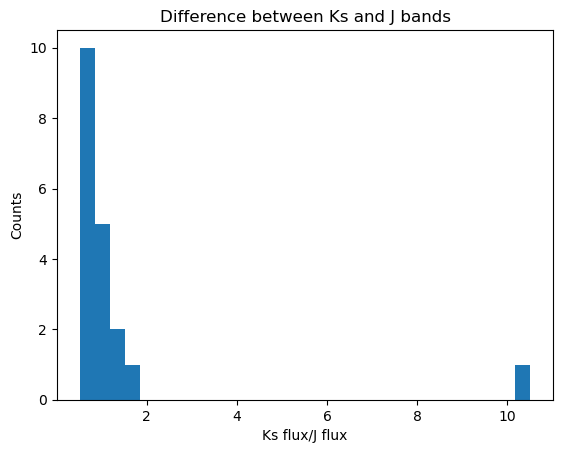

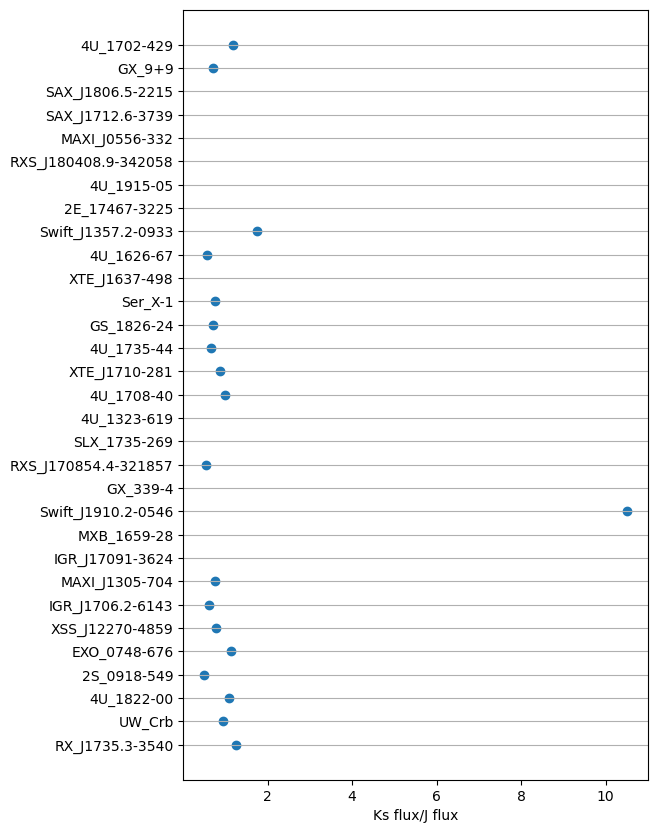

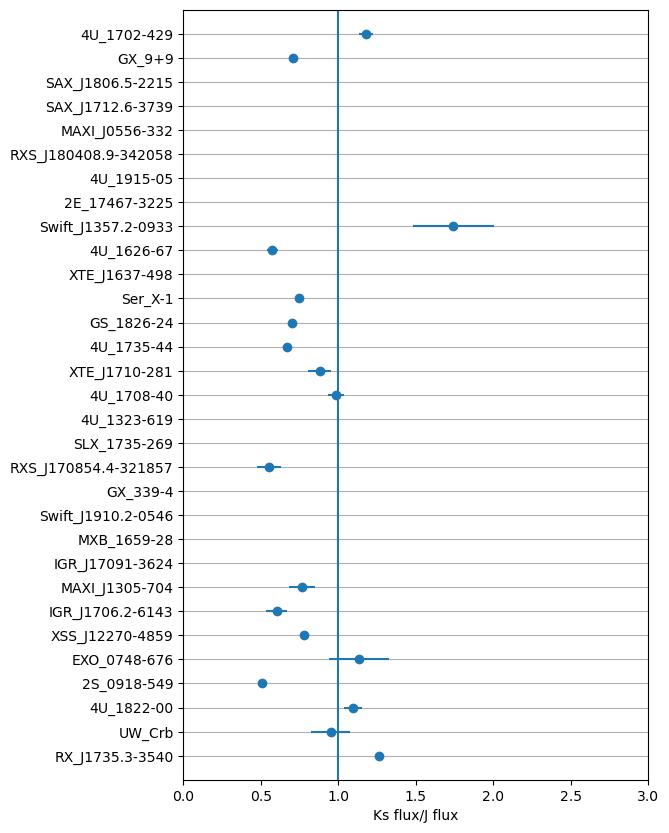

In [109]:
plt.hist(ratio_list, bins=30)
plt.xlabel('Ks flux/J flux')
plt.ylabel('Counts')
plt.title('Difference between Ks and J bands')
plt.show()

# plt.figure(figsize=(10,6))
# plt.scatter(source_list, ratio_list)
# plt.xticks(rotation = 90)
# plt.show()

plt.figure(figsize=(6,10))
plt.scatter(ratio_list, source_list)
plt.grid(axis='y')
plt.xlabel('Ks flux/J flux')
plt.show()


plt.figure(figsize=(6,10))
# plt.scatter(ratio_list, source_list)
plt.errorbar(ratio_list, source_list, xerr=error_list, fmt="o")
plt.grid(axis='y')
plt.vlines(1, -1, 32)
plt.ylim(-1,31)
plt.xlim(0, 3)
plt.xlabel('Ks flux/J flux')
plt.show()

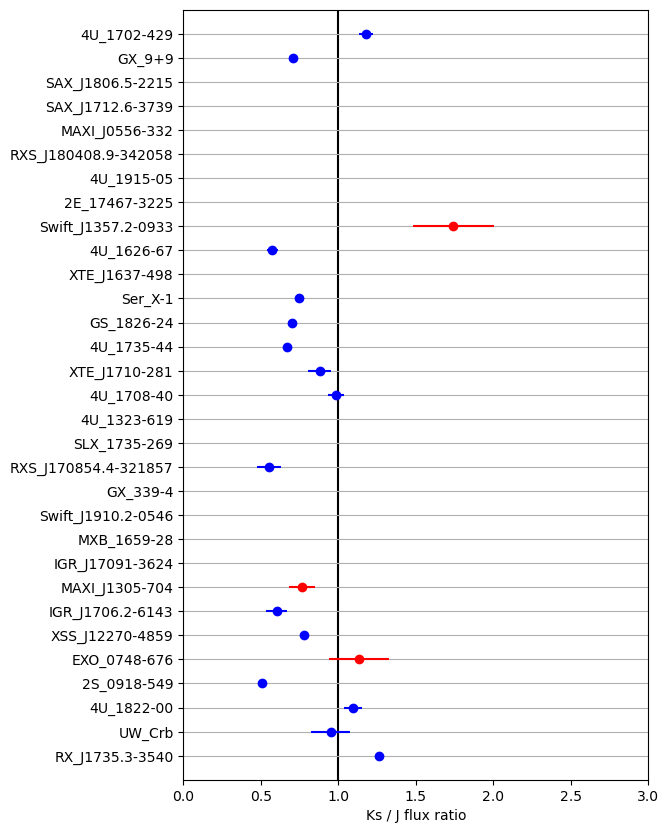

In [123]:
plt.figure(figsize=(6,10))
for n, s in enumerate(source_list):
    if s in quiescent_sources: 
        c = 'Red'
    else:
        c = 'Blue'
#     plt.scatter(ratio_list[n], source_list[n], color=c, zorder=10)
    plt.errorbar(ratio_list[n], range(len(source_list))[n], xerr=error_list[n], fmt="o", color=c, zorder=10)
plt.yticks(range(len(source_list)), source_list)
plt.grid(axis='y', zorder=-1)
plt.vlines(1, -1, 32, color='k', zorder=-1)
plt.ylim(-1,31)
plt.xlim(0, 3)
plt.xlabel('Ks / J flux ratio')
plt.show()

## Count observations

In [11]:
'''
Count how many magnitude measurements there are (no upplim)
''' 

Ks = 0
H = 0
J = 0

for i, s in enumerate(source_list):
        
    # Get Ks magnitude
    Ks_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'Ks')]
    if len(Ks_obs) > 0:
        Ks += 1
        
    # Get Ks magnitude
    J_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'J')]
    if len(J_obs) > 0:
        J += 1
        
    # Get Ks magnitude
    H_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'H')]
    if len(H_obs) > 0:
        H += 1

print('amount of sources with magnitude measurement (no upplim):', len(tbl_mags.groupby('Source')))        
print('amount of sources with Ks obs: ', Ks, '(', round(Ks/len(tbl_mags.groupby('Source'))*100,1 ), '%)')        
print('amount of sources with H  obs: ', H, '(', round(H/len(tbl_mags.groupby('Source'))*100,1 ), '%)')             
print('amount of sources with J  obs: ', J, '(', round(J/len(tbl_mags.groupby('Source'))*100,1 ), '%)')             

amount of sources with magnitude measurement (no upplim): 31
amount of sources with Ks obs:  29 ( 93.5 %)
amount of sources with H  obs:  28 ( 90.3 %)
amount of sources with J  obs:  21 ( 67.7 %)


In [12]:
'''
Count how many total measurements there are (can also be upplim)
''' 

tot_source_list = tbl['Source'].unique()

Ks = 0
H = 0
J = 0

for i, s in enumerate(tot_source_list):
        
    # Get Ks magnitude
    Ks_obs = tbl[(tbl['Source'] == s) & (tbl['Filter'] == 'Ks')]
    if len(Ks_obs) > 0:
        Ks += 1
        
    # Get Ks magnitude
    J_obs = tbl[(tbl['Source'] == s) & (tbl['Filter'] == 'J')]
    if len(J_obs) > 0:
        J += 1
        
    # Get Ks magnitude
    H_obs = tbl[(tbl['Source'] == s) & (tbl['Filter'] == 'H')]
    if len(H_obs) > 0:
        H += 1

print('amount of sources with any measurement:', len(tbl.groupby('Source')))        
print('amount of sources with Ks obs: ', Ks, '(', round(Ks/len(tbl.groupby('Source'))*100,1 ), '%)')        
print('amount of sources with H  obs: ', H, '(', round(H/len(tbl.groupby('Source'))*100,1 ), '%)')             
print('amount of sources with J  obs: ', J, '(', round(J/len(tbl.groupby('Source'))*100,1 ), '%)')             

amount of sources with any measurement: 38
amount of sources with Ks obs:  35 ( 92.1 %)
amount of sources with H  obs:  33 ( 86.8 %)
amount of sources with J  obs:  22 ( 57.9 %)


## Investigate magnitude values

In [13]:
source_list = tbl_mags['Source'].unique()
Ks_mags = []
H_mags = []
J_mags = []

for i, s in enumerate(source_list):
        
    # Get Ks magnitude
    Ks_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'Ks')]
    if len(Ks_obs) > 1:
        Ks_mag = np.mean(Ks_obs['Mag_corr'])
    else: 
        Ks_mag = np.mean(Ks_obs['Mag_corr'])
        
    # Get J magnitude
    J_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'J')]
    if len(J_obs) > 1:
        J_mag = np.mean(J_obs['Mag_corr'])
    else: 
        J_mag = np.mean(J_obs['Mag_corr'])
        
    # Get H magnitude
    H_obs = tbl_mags[(tbl_mags['Source'] == s) & (tbl_mags['Filter'] == 'H')]
    if len(H_obs) > 1:
        H_mag = np.mean(H_obs['Mag_corr'])
    else: 
        H_mag = np.mean(H_obs['Mag_corr'])
        
    # Store magnitude values
    Ks_mags.append(Ks_mag)
    J_mags.append(J_mag)
    H_mags.append(H_mag)

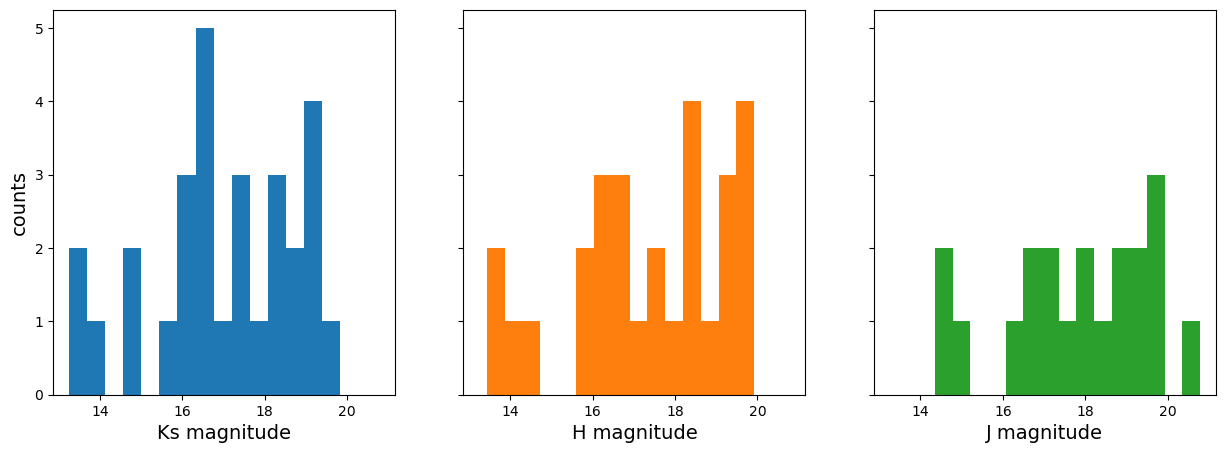

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharey=True, sharex=True)
ax1.hist(Ks_mags, bins=15)
ax1.set_xlabel('Ks magnitude', fontsize=14)
ax2.hist(H_mags, bins=15, color='C1')
ax2.set_xlabel('H magnitude', fontsize=14)
ax3.hist(J_mags, bins=15, color='C2')
ax3.set_xlabel('J magnitude', fontsize=14)
ax1.set_ylabel('counts', fontsize=14)
plt.show()


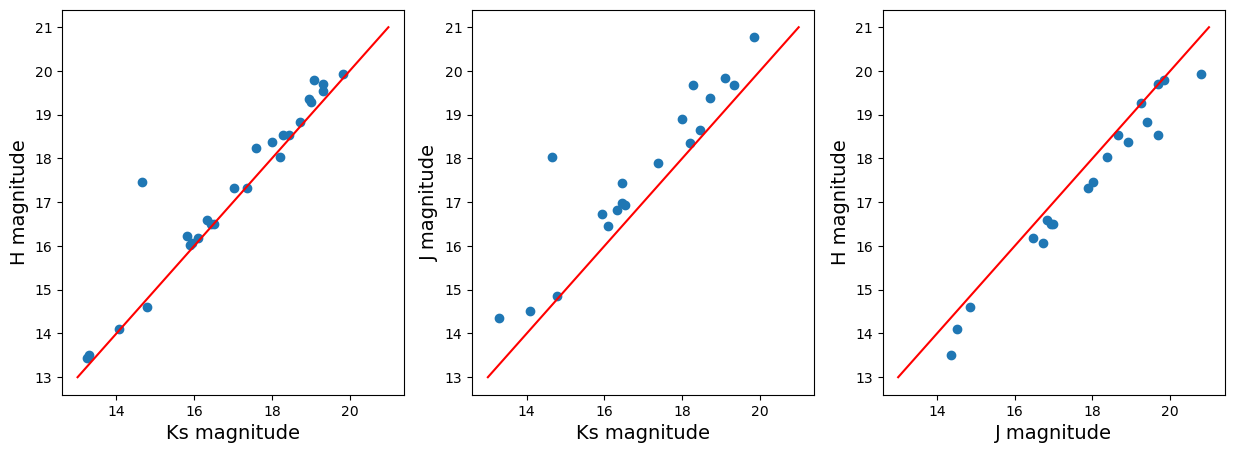

In [15]:
x = np.linspace(13, 21, 20)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.scatter(Ks_mags, H_mags)
ax1.set_xlabel('Ks magnitude', fontsize=14)
ax1.set_ylabel('H magnitude', fontsize=14)
ax1.plot(x, x, 'red')

ax2.scatter(Ks_mags, J_mags)
ax2.set_xlabel('Ks magnitude', fontsize=14)
ax2.set_ylabel('J magnitude', fontsize=14)
ax2.plot(x, x, 'red')

ax3.scatter(J_mags, H_mags)
ax3.set_xlabel('J magnitude', fontsize=14)
ax3.set_ylabel('H magnitude', fontsize=14)
ax3.plot(x, x, 'red')
plt.show()

(20.246879961999998, 13.111721118)

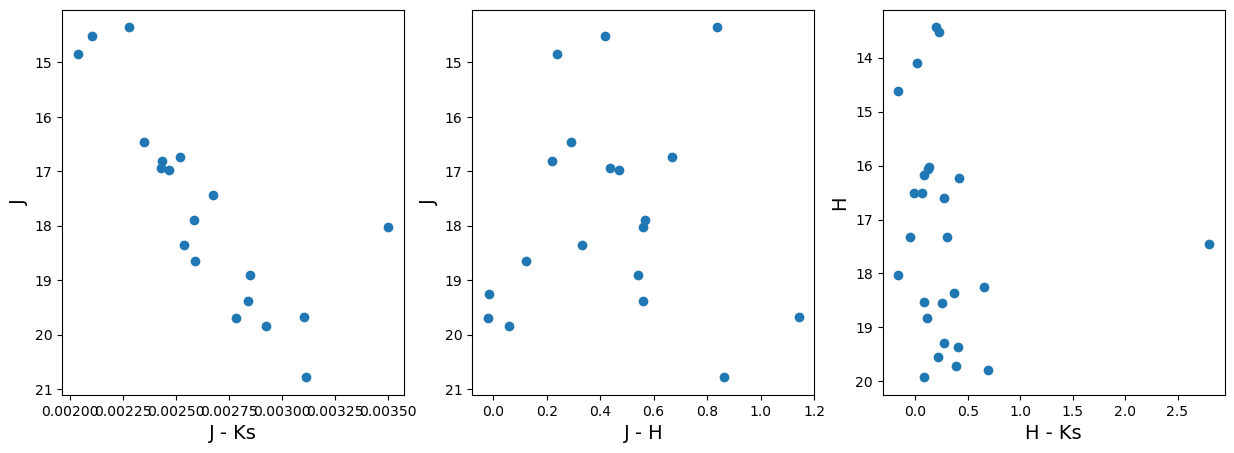

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.scatter(dif_list, J_mags)
ax1.set_xlabel('J - Ks', fontsize=14)
ax1.set_ylabel('J', fontsize=14)
ax1.set_ylim(reversed(ax1.set_ylim())) # flip the y-axis

ax2.scatter([J_mags[i] - H_mags[i] for i in range(len(H_mags))], J_mags)
ax2.set_xlabel('J - H', fontsize=14)
ax2.set_ylabel('J', fontsize=14)
ax2.set_ylim(reversed(ax2.set_ylim())) # flip the y-axis

ax3.scatter([H_mags[i] - Ks_mags[i] for i in range(len(Ks_mags))], H_mags)
ax3.set_xlabel('H - Ks', fontsize=14)
ax3.set_ylabel('H', fontsize=14)
ax3.set_ylim(reversed(ax3.set_ylim())) # flip the y-axis

## Show source positions

In [17]:
ra_list = []
dec_list = []
color_list = []
for i in tbl.groupby('Source')['RA'].apply(list):
    ra_list.append(i[0])
for i in tbl.groupby('Source')['DEC'].apply(list):
    dec_list.append(i[0])
for i in tbl.groupby('Source')['nH'].apply(list):
    color_list.append(i[0])
    
coo_list = []
for i in range(len(ra_list)):
    crd = ra_list[i] + ' ' + dec_list[i]
    coo_list.append(crd)
    
skycrd = SkyCoord(coo_list, unit=(u.hourangle,u.deg))
ra = coord.Angle(skycrd.ra)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(skycrd.dec)

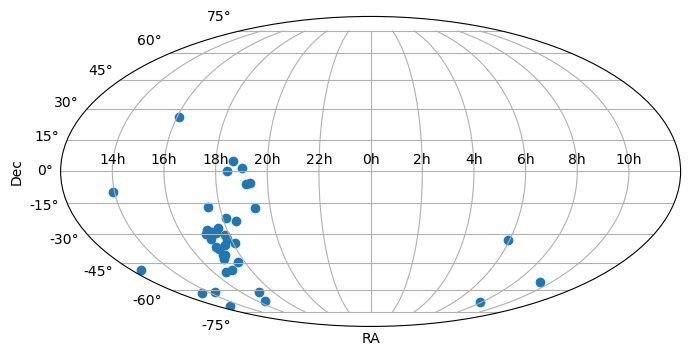

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()


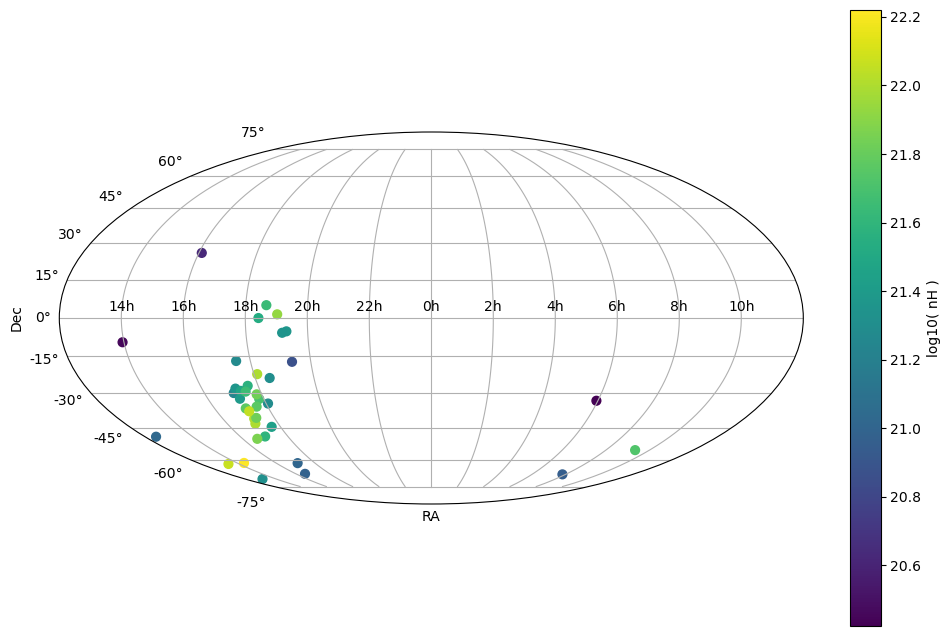

In [19]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
scatterplot = ax.scatter(ra.radian, dec.radian, c=[np.log10(i) for i in color_list], s=40)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
fig.colorbar(scatterplot, label='log10( nH )')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()

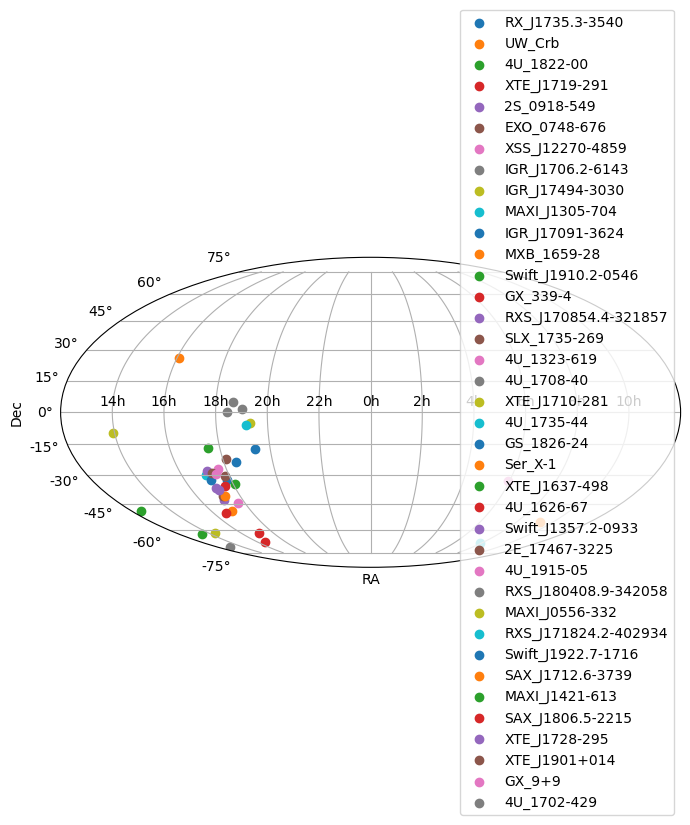

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
for i in range(len(tot_source_list)):
    ax.scatter(ra[i].radian, dec[i].radian, label=tot_source_list[i])
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend(loc='right')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()

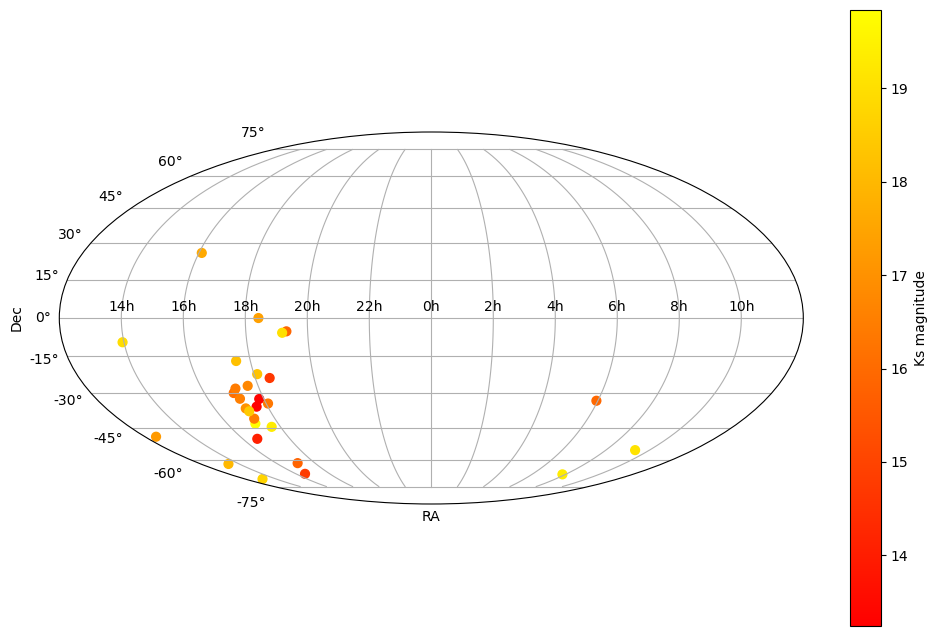

In [21]:
ra_list = []
dec_list = []
color_list = []
for i in tbl_mags.groupby('Source')['RA'].apply(list):
    ra_list.append(i[0])
for i in tbl_mags.groupby('Source')['DEC'].apply(list):
    dec_list.append(i[0])
for i in tbl_mags.groupby('Source')['nH'].apply(list):
    color_list.append(i[0])
    
coo_list = []
for i in range(len(ra_list)):
    crd = ra_list[i] + ' ' + dec_list[i]
    coo_list.append(crd)
    
skycrd = SkyCoord(coo_list, unit=(u.hourangle,u.deg))
ra = coord.Angle(skycrd.ra)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(skycrd.dec)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
scatterplot = ax.scatter(ra.radian, dec.radian, c=Ks_mags, s=40, cmap='autumn')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
fig.colorbar(scatterplot, label='Ks magnitude')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()

## Spread of offsets


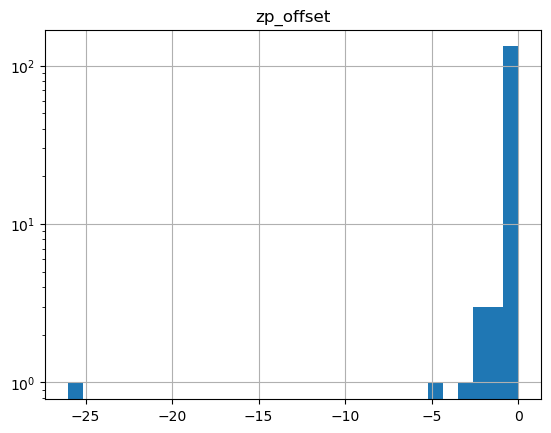

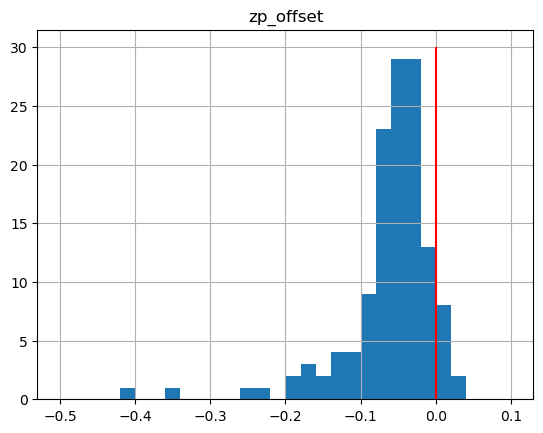

In [22]:
tbl.hist('zp_offset', bins=30)
plt.yscale('log')
tbl.hist('zp_offset', bins=30, range=[-1/2, 0.1])
plt.vlines(0, 0, 30, color='Red')

array([[<AxesSubplot:title={'center':'Astrometric_err'}>]], dtype=object)

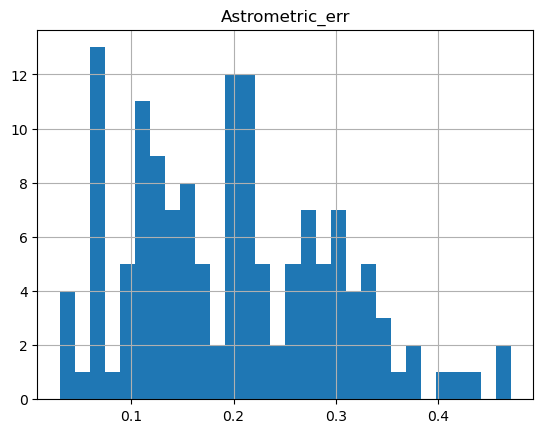

In [23]:
tbl.hist('Astrometric_err', bins=30)